# Test Plot Latence

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
from lmfit import  Model, Parameters
%matplotlib inline

In [2]:
timeStr = '2017-07-21_142241'
observer = 'laurent'
mode = 'enregistrement'

In [3]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [4]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [5]:
def vitesse (x, tau=0.013, xT=0.01, t_T=0.2, start=1200., bino=1) :
    '''
    tau -- constante oeuil (0.013)
    xT -- position en deg de la cible (1)
    t_T -- tps du mvt - s (0.1)
    start -- tps où commence le mvt
    bino -- binomial
    '''    
    if bino == 0:
        xT =xT*(-1)
    
    dt = 0.001
    T = int(t_T/dt) # tps termine mvt - ms
    time = np.arange(len(x))/1000 # en seconde !!!
    start = start/1000 # en seconde
    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N

    vitesse = []
    for t in range(len(time)):
        if bino==0 :
            if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) > 0 :
                vitesse.append(0)
            else :
                vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
        else :
            if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) < 0 :
                vitesse.append(0)
            else :
                vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
    return vitesse

In [6]:
Latences = []
for block in range(N_blocks) :
    l=[]
    
    for trial in range(N_trials) :
        
        trial_data = trial + N_trials*block

        data_x = data[trial_data]['x']
        trackertime = data[trial_data]['trackertime']
        TargetOn = data[trial_data]['events']['msg'][15][0]
        saccades = data[trial_data]['events']['Esac']

        gradient_x = np.gradient(data_x)
        
        # SUPPRESSION DES SACCADES
        new_gradient_x=[]
        new_time=[]
        t=0
        for x_data in range(len(data_x)):
            saccade = None
            for s in range(len(saccades)) :
                if x_data in np.arange((saccades[s][0]-trackertime[0]), (saccades[s][1]-trackertime[0]+1+4)) :
                    saccade = 'yes'
            if not saccade :
                new_gradient_x.append(gradient_x[x_data])
                new_time.append(t)
                t = t+1
            saccade = None
        
        # FIT
        model = Model(vitesse)

        bino=p[trial, block, 0]
        params = Parameters()
        params.add('tau', value=0.013, min=0.001, max=0.1, vary=False)
        params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
        params.add('t_T', value= 0.1, min=0.001, max=0.2, vary=False)
        params.add('start', value=1000., min=0, max=2000.)#, vary=True)
        params.add('bino', value=bino, min=0, max=1, vary=False)

        result = model.fit(new_gradient_x, params, x=new_time)

        debut  = TargetOn-trackertime[0]

        liste_l =[]
        dir_bool = bino*2 - 1
        for tps in range(len(new_time)) :
            if dir_bool*result.best_fit[tps] > 0.003 :
                liste_l.append(new_time[tps])
        if len(liste_l)!=0:
            latence = liste_l[0]
        else:
            print('pas de latence pour block %s, essaie %s'%(block, trial))
        l.append(latence-debut)
    Latences.append(l)

In [7]:
matrice_latences = np.asarray(Latences)

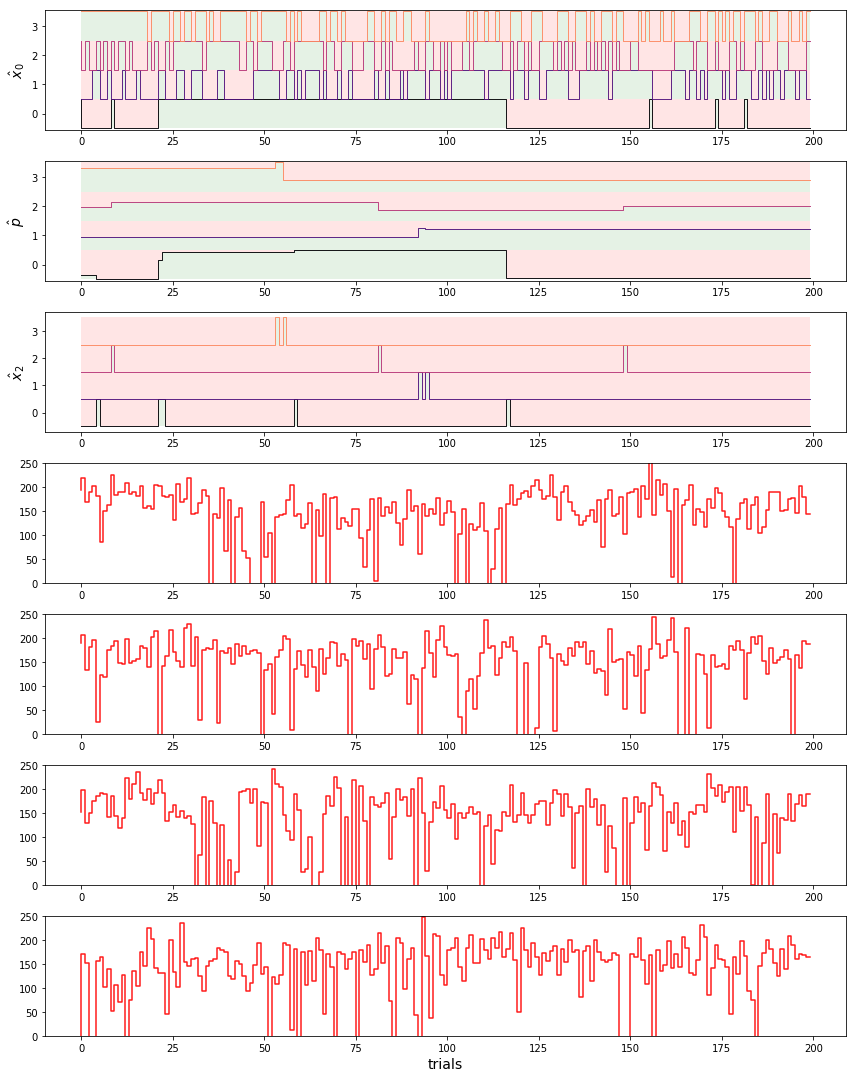

In [8]:
fig_width= 12
fig, axs = plt.subplots(7, 1, figsize=(fig_width, fig_width*2/1.6180))

stick = np.zeros_like(p)
stick[:, :, 0] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
stick[:, :, 1] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
stick[:, :, 2] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
corrects = 0

for i_layer, label in enumerate([r'$\^x_0$', r'$\^p$', r'$\^x_2$']):
    from cycler import cycler
    axs[i_layer].set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_blocks+1)]))
    _ = axs[i_layer].step(range(N_trials), p[:, :, i_layer]+stick[:, :, i_layer], lw=1, alpha=.9)
    for i_block in range(N_blocks):
        _ = axs[i_layer].fill_between(range(N_trials), i_block + np.zeros_like(p[:, i_block, i_layer]), i_block + p[:, i_block, i_layer], lw=.5, alpha=.1, facecolor='green', step='pre')
        _ = axs[i_layer].fill_between(range(N_trials), i_block + np.ones_like(p[:, i_block, i_layer]), i_block + p[:, i_block, i_layer], lw=.5, alpha=.1, facecolor='red', step='pre')
    axs[i_layer].axis('tight')
    axs[i_layer].set_yticks(np.arange(N_blocks)+.5)
    axs[i_layer].set_yticklabels(np.arange(N_blocks) )
    axs[i_layer].set_ylabel(label, fontsize=14)

for block in range(N_blocks):
    _ = axs[3+block].step(range(N_trials), matrice_latences[block,:], alpha=.9, color='r')
    axs[3+block].set_ylim(0, 250)

fig.tight_layout()
for i in range(2): axs[i].set_ylim(-.05, N_blocks + .05)
axs[-1].set_xlabel('trials', fontsize=14);

plt.show()

TODO: scatter plot pour chaque agent de la latence en fonction de la valeur de p - seaborn permet de calculer le coeff de correlation